# GPyTorch Regression Tutorial

Adjust the example from [the online doc](https://docs.gpytorch.ai/en/v1.12/examples/01_Exact_GPs/Simple_GP_Regression.html) using different training data.

## Imports

In [49]:
import logging
import math

from dotenv import load_dotenv

import gpytorch

from matplotlib import pyplot as plt

import numpy as np

import seaborn as sns

import torch


%load_ext autoreload
%autoreload 2

# Logger
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%I:%M:%S'
)

# Load dotenv
_ = load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define training data

In [50]:
from gp_sand.generate import NoisyPCGenerator

gene = NoisyPCGenerator(noise=0.1, power_rated=100000)

ws, power, ws_true = gene.generate()

## Visualize training data

<Axes: ylabel='Density'>

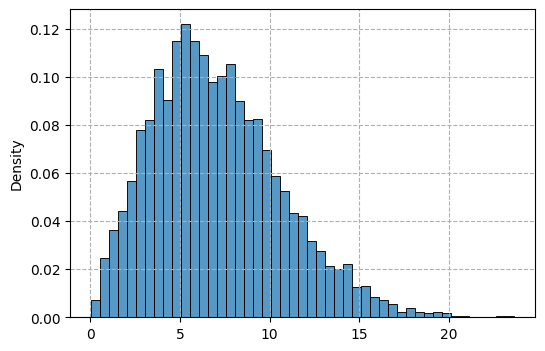

In [51]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.histplot(
    x=ws_true,
    binwidth=.5,
    pthresh=0.01,
    stat='density',
)

# ax.set(xlim=(-15, 15))

<Axes: >

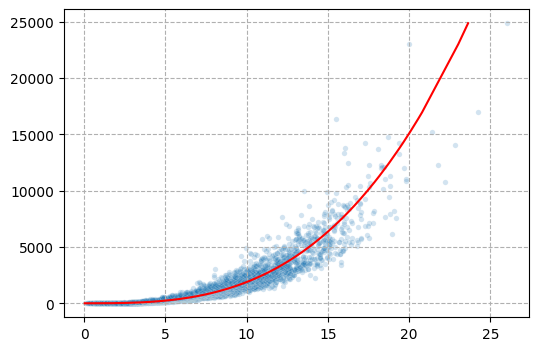

In [52]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.lineplot(
    x=ws_true,
    y=power,
    zorder=10,
    color='r'
)

sns.scatterplot(
    x=ws,
    y=power,
    s=15,
    alpha=.2,
)

## Set up the Model

In [53]:
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(
            self,
            inducing_points: torch.Tensor
        ):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-1))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Fit the model

In [54]:
x_train = torch.tensor(ws).to(torch.float32)
y_train = torch.tensor(power).to(torch.float32)

In [59]:
n_ind = 150
points = (
    torch.tensor(
        np.percentile(
            ws,
            np.linspace(0, 1, n_ind)
        )
    ).to(torch.float32)
)
model = ApproximateGPModel(points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()


n_epochs: int = 2000

# Find optimal hyperparameters
model.train()
likelihood.train()

# Use Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Objective function
obj = gpytorch.mlls.PredictiveLogLikelihood(
    likelihood,
    model,
    num_data=y_train.numel()
)

for n in range(n_epochs):
    # Set 0-gradient
    optimizer.zero_grad()

    # Get the output
    pred = model(x_train)

    # Loss and backward
    loss = -obj(pred, y_train)
    loss.backward()
    optimizer.step()

    # Logger
    if (n + 1) % 50 == 0:
        logger.info(f'Iter {n + 1} of {n_epochs} - Loss: {loss.item()}')

05:50:27 INFO: Iter 50 of 2000 - Loss: 14670.216796875
05:50:28 INFO: Iter 100 of 2000 - Loss: 252.9993896484375
05:50:29 INFO: Iter 150 of 2000 - Loss: 199.00698852539062
05:50:30 INFO: Iter 200 of 2000 - Loss: 166.1626434326172
05:50:31 INFO: Iter 250 of 2000 - Loss: 142.19973754882812
05:50:32 INFO: Iter 300 of 2000 - Loss: 124.88414764404297
05:50:33 INFO: Iter 350 of 2000 - Loss: 112.29098510742188
05:50:34 INFO: Iter 400 of 2000 - Loss: 102.89430236816406
05:50:35 INFO: Iter 450 of 2000 - Loss: 95.75483703613281
05:50:36 INFO: Iter 500 of 2000 - Loss: 90.07810974121094
05:50:37 INFO: Iter 550 of 2000 - Loss: 85.4203109741211
05:50:38 INFO: Iter 600 of 2000 - Loss: 81.54106140136719
05:50:39 INFO: Iter 650 of 2000 - Loss: 78.27885437011719
05:50:40 INFO: Iter 700 of 2000 - Loss: 75.42214965820312
05:50:42 INFO: Iter 750 of 2000 - Loss: 72.96855163574219
05:50:43 INFO: Iter 800 of 2000 - Loss: 70.72050476074219
05:50:44 INFO: Iter 850 of 2000 - Loss: 68.72203063964844
05:50:45 INFO

## Posterior predictive

In [60]:
model.eval()
likelihood.eval()

_, pw_test, ws_test = gene.generate(1500)

x_test = torch.tensor(ws_test).to(torch.float32)
with torch.no_grad():

    f_dist = model(x_test)
    mean = f_dist.mean
    f_lower, f_upper = f_dist.confidence_region()
    y_dist = likelihood(f_dist)
    y_lower, y_upper = y_dist.confidence_region()

## Visu

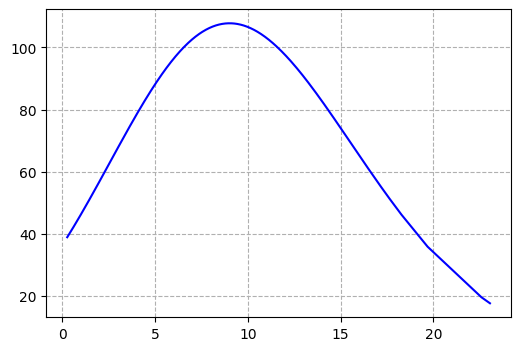

In [62]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

# ax.plot(ws_test, pw_test, ls='--', c='r')
ax.plot(x_test, mean, lw=1.5, c='blue')

In [58]:
ws_true[ind.numpy()]

array([2.90852411, 3.94921223, 3.25989527, ..., 3.63524427, 0.70294854,
       4.11320449], shape=(1250,))